# Предсказание показателя "Классификатор 1 уровня"

In [ ]:
# Импорт библиотек

import pandas as pd
import numpy as np
import torch
import math
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer, AutoModel
from tensorflow.keras.layers import Input, Bidirectional, Dropout, BatchNormalization, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
import tf2onnx
from keras.utils import plot_model


Загрузим базу знаний и посмотрим на данные

In [ ]:
faq = pd.read_excel("01_База_знаний.xlsx")
faq.head()

,Тема,Вопрос из БЗ,Ответ из БЗ,Классификатор 1 уровня,Классификатор 2 уровня
0,Что нельзя публиковать на RUTUBE,Что нельзя публиковать на RUTUBE?,Чужой контент без разрешения автора или правоо...,МОДЕРАЦИЯ,Отклонение/блокировка видео
1,Почему могут отключить монетизацию на видео и ...,Почему могут отключить монетизацию из-за автор...,"Монетизация может отключиться, если на вашем к...",МОНЕТИЗАЦИЯ,Отключение/подключение монетизации
2,Почему могут отключить монетизацию на видео и ...,Почему могут отключить монетизацию из-за искус...,Монетизация на RUTUBE зависит в том числе от к...,МОНЕТИЗАЦИЯ,Отключение/подключение монетизации
3,Почему могут отключить монетизацию на видео и ...,"Для каких статусов доступна монетизация, и поч...","Монетизацию на RUTUBE можно подключить, если в...",МОНЕТИЗАЦИЯ,Отключение/подключение монетизации
4,Авторское право,Какой контент можно использовать для монетизац...,"То, что вы создали сами: видео, которое вы сня...",МОНЕТИЗАЦИЯ,Отключение/подключение монетизации


Удалим из датасета колонки, которые не используются для предсказания показателя "Классификатор 1 уровня" (колонки "Тема" и "Ответ из БЗ" не используются по той причине, что их нельзя извлечь из пользовательского соглашения, а колонки "Классификатор 2 уровня" используется для другой задачи)

In [ ]:
faq = faq.drop(['Тема', 'Ответ из БЗ', 'Классификатор 2 уровня'], axis=1)
faq.head()

,Вопрос из БЗ,Классификатор 1 уровня
0,Что нельзя публиковать на RUTUBE?,МОДЕРАЦИЯ
1,Почему могут отключить монетизацию из-за автор...,МОНЕТИЗАЦИЯ
2,Почему могут отключить монетизацию из-за искус...,МОНЕТИЗАЦИЯ
3,"Для каких статусов доступна монетизация, и поч...",МОНЕТИЗАЦИЯ
4,Какой контент можно использовать для монетизац...,МОНЕТИЗАЦИЯ


Переименуем колонки более лаконично для удобства

In [ ]:
faq.rename(columns={
    'Вопрос из БЗ': 'question',
    'Классификатор 1 уровня': 'class'
}, inplace=True)

Загрузим данные о реальных кейсах и посмотрим на них

In [ ]:
data = pd.read_excel("02_Реальные_кейсы.xlsx")
data.head()

,Вопрос пользователя,Ответ сотрудника,Вопрос из БЗ,Ответ из БЗ,Классификатор 1 уровня,Классификатор 2 уровня
0,Здравствуйте! Можно уточнить причины Правилhtt...,Добрый день!\nЧто нельзя публиковать на RUTUBE...,Что нельзя публиковать на RUTUBE?,Чужой контент без разрешения автора или правоо...,МОДЕРАЦИЯ,Отклонение/блокировка видео
1,"Добрый вечер, какой топ причин блокировки виде...",Добрый вечер!\nЧто заперщено публиковать на RU...,Что нельзя публиковать на RUTUBE?,Чужой контент без разрешения автора или правоо...,МОДЕРАЦИЯ,Отклонение/блокировка видео
2,"Все пишут, что монетизация на рутубе отключает...","Добрый день! \nМонетизация может отключиться, ...",Почему могут отключить монетизацию из-за автор...,"Монетизация может отключиться, если на вашем к...",МОНЕТИЗАЦИЯ,Отключение/подключение монетизации
3,Что запрещено в монетизации и что можно выклад...,"Здравствуйте!\nМонетизация может отключиться, ...",Почему могут отключить монетизацию из-за автор...,"Монетизация может отключиться, если на вашем к...",МОНЕТИЗАЦИЯ,Отключение/подключение монетизации
4,"Чтобы не отключали монетизацию, надо, чтобы я ...","Для монетизации можно использовать то, что вы ...",Почему могут отключить монетизацию из-за автор...,"Монетизация может отключиться, если на вашем к...",МОНЕТИЗАЦИЯ,Отключение/подключение монетизации


Удалим лишние колонки так, чтобы оставшиеся соответствовали колонкам базы знаний (датасет faq)

In [ ]:
data = data.drop(['Ответ сотрудника', 'Вопрос из БЗ', 'Ответ из БЗ', 'Классификатор 2 уровня'], axis=1)
data.head()

,Вопрос пользователя,Классификатор 1 уровня
0,Здравствуйте! Можно уточнить причины Правилhtt...,МОДЕРАЦИЯ
1,"Добрый вечер, какой топ причин блокировки виде...",МОДЕРАЦИЯ
2,"Все пишут, что монетизация на рутубе отключает...",МОНЕТИЗАЦИЯ
3,Что запрещено в монетизации и что можно выклад...,МОНЕТИЗАЦИЯ
4,"Чтобы не отключали монетизацию, надо, чтобы я ...",МОНЕТИЗАЦИЯ


Переименуем колонки аналогичным образом

In [ ]:
data.rename(columns={
    'Вопрос пользователя': 'question',
    'Классификатор 1 уровня': 'class',
}, inplace=True)

Объединим датасеты, чтобы посмотреть на полный набор имеющихся данных

In [ ]:
df = pd.concat([faq, data], ignore_index=True)
df

,question,class
0,Что нельзя публиковать на RUTUBE?,МОДЕРАЦИЯ
1,Почему могут отключить монетизацию из-за автор...,МОНЕТИЗАЦИЯ
2,Почему могут отключить монетизацию из-за искус...,МОНЕТИЗАЦИЯ
3,"Для каких статусов доступна монетизация, и поч...",МОНЕТИЗАЦИЯ
4,Какой контент можно использовать для монетизац...,МОНЕТИЗАЦИЯ
...,...,...
1122,Добрый день! Как добавить таймкоды в видео?,ВИДЕО
1123,Как добавить временные интервалы,ВИДЕО
1124,В каком формате добавляются таймкоды?,ВИДЕО
1125,Как мне правильно указать тайм-код?,ВИДЕО


In [ ]:
#информация о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  1127 non-null   object
 1   class     1127 non-null   object
dtypes: object(2)
memory usage: 17.7+ KB


In [ ]:
# количество классов в датасете с базой знаний
len(faq['class'].unique())

11

In [ ]:
# количество классов в датасете с реальными кейсами
len(data['class'].unique())

11

Как видим, классов одинаковое количество, но нужно убедиться, что они одинаковые

In [ ]:
faq['class'].unique().sort() == data['class'].unique().sort()

True

Действительно, это так

In [ ]:
# названия всех классов
df['class'].unique()

array(['МОДЕРАЦИЯ', 'МОНЕТИЗАЦИЯ', 'УПРАВЛЕНИЕ АККАУНТОМ',
       'ДОСТУП К RUTUBE', 'ОТСУТСТВУЕТ', 'ПРЕДЛОЖЕНИЯ', 'ВИДЕО',
       'ТРАНСЛЯЦИЯ', 'СОТРУДНИЧЕСТВО ПРОДВИЖЕНИЕ РЕКЛАМА', 'ПОИСК',
       'БЛАГОТВОРИТЕЛЬНОСТЬ ДОНАТЫ'], dtype=object)

Посмотрим на распределение данных по классам

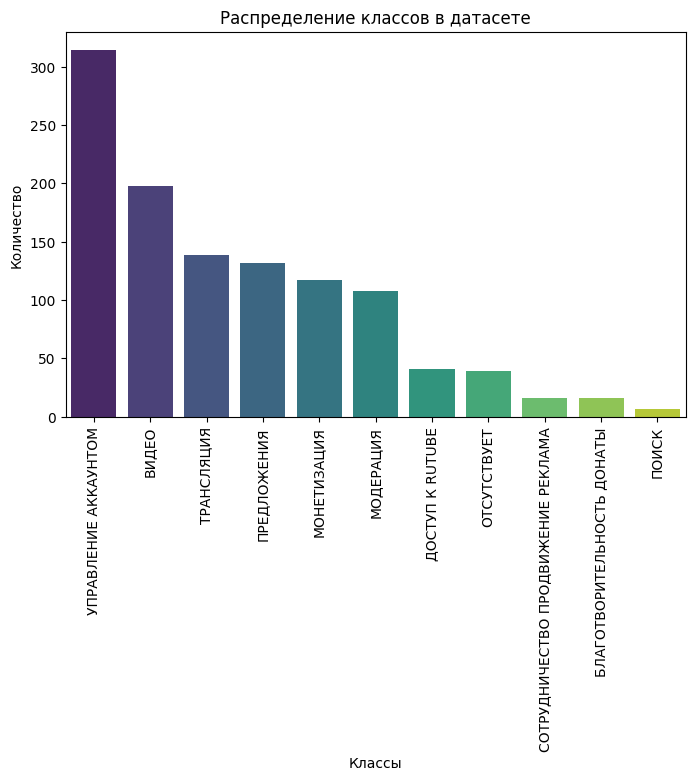

In [ ]:
# Получаем количество экземпляров каждого класса
class_counts = df['class'].value_counts()

# Создаем фигуру с заданными размерами
plt.figure(figsize=(8, 5))

# Создаем столбчатую диаграмму с использованием библиотеки seaborn
# x - метки классов, y - соответствующее количество классов
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

plt.xlabel('Классы')

plt.ylabel('Количество')

plt.title('Распределение классов в датасете')

plt.xticks(rotation=90)

plt.show()

В данных наблюдается сильный дисбаланс классов, чтобы решить эту проблему, был сгенерирован датасет, в котором к базе знаний вручную были добавлены синтетические данные путем перефразирования уже имеющихся вопросов, классы которых имеются в малом наличии в датасете

In [ ]:
# база знаний с синтетическими данными
synth_data = pd.read_csv('synth_data.csv')

In [ ]:
synth_data

,question,class
0,Как очистить список посещенных страниц?,ПОИСК
1,Как стереть историю просмотренных сайтов?,ПОИСК
2,Как избавиться от списка недавно открытых вкла...,ПОИСК
3,Как удалить историю просмотров?,ПОИСК
4,Как очистить журнал посещений?,ПОИСК
...,...,...
1557,"Что делать, если мой браузер не загружает стра...",ОТСУТСТВУЕТ
1558,"Как быть, если мой веб-браузер не отображает к...",ОТСУТСТВУЕТ
1559,"Что делать, если мой интернет-обозреватель не ...",ОТСУТСТВУЕТ
1560,Можно ли загрузить видео с RUTUBE?,ОТСУТСТВУЕТ


Объединяем синтетические данные, данные базы знаний и данные реальных кейсов, чтобы посмотреть, как изменилось распределение данных

In [ ]:
df = pd.concat([synth_data, data], ignore_index=True)

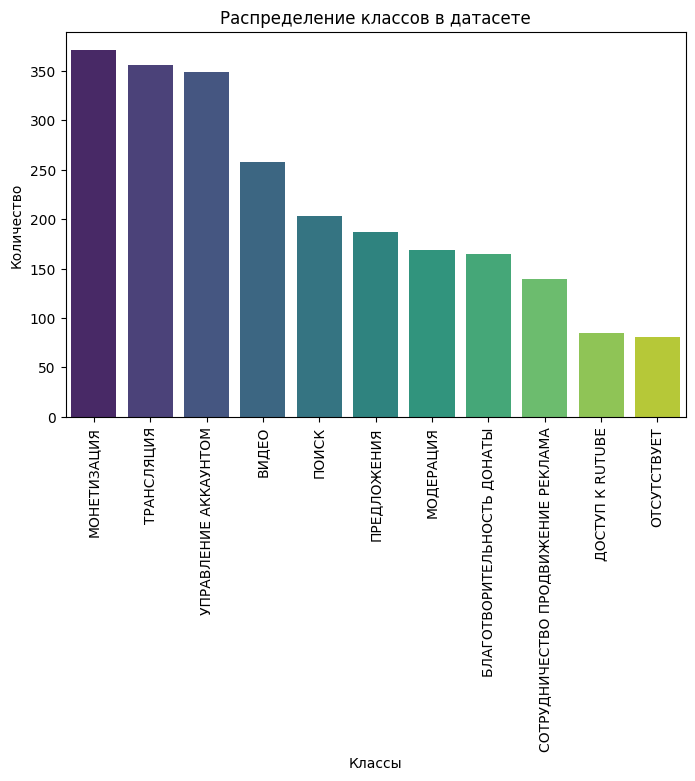

In [ ]:
df = pd.concat([synth_data, data], ignore_index=True)

class_counts = df['class'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

plt.xlabel('Классы')
plt.ylabel('Количество')
plt.title('Распределение классов в датасете')

plt.xticks(rotation=90)

plt.show()

Как видим, дизбаланс стал не таким резким, но еще больше синтетических данных не было добавлено, чтобы не пострадало качество модели

Далее поделим данные на тестовую и тренировочную выборки, при этом на обучение идут синтетические данные, данные базы знаний и часть данных реальных кейсов, а на тест идут только данные из реальных кейсов

In [ ]:
# выбрано именно такое соотношение (0.85/0.15) для соблюдения баланса между значимостью количества данных для обучения и валидации
train_data, test_data = train_test_split(data, test_size=0.15, stratify=data['class'], random_state=22)

In [ ]:
train_data = pd.concat([synth_data, train_data], ignore_index=True)

In [ ]:
train_data

,question,class
0,Как очистить список посещенных страниц?,ПОИСК
1,Как стереть историю просмотренных сайтов?,ПОИСК
2,Как избавиться от списка недавно открытых вкла...,ПОИСК
3,Как удалить историю просмотров?,ПОИСК
4,Как очистить журнал посещений?,ПОИСК
...,...,...
2237,Как в студии рутуба на телефоне создать свой п...,ПРЕДЛОЖЕНИЯ
2238,Почнм нельзя смотреть видео в хорошем качестве?,ВИДЕО
2239,У вас работает перемотка на трансляциях?,ТРАНСЛЯЦИЯ
2240,"пройдет видео модерация, если цитировать чужие...",МОДЕРАЦИЯ


In [ ]:
X_train = train_data['question']
y_train = train_data['class']

X_test = test_data['question']
y_test = test_data['class']

Во время подбора моделей было протестировано множество различных классических ML-моделей, таких как: логистическая регрессия, наивный баес, случайный лес, градиентный бустинг, XGBoost, Catboost, бэггинг, некоторые обнучались с кросс-валидацией. Был испробован семантический поиск, а также несколько архитектур нейронных сетей.
Но самой лучшей по метрикам accuracy и f1-score является подход классификации текстачерез LSTM с Attantion (этот же подход будет испольваться для классификации класса 2 уровня).

In [ ]:
# Загружаем токенизатор и модель из указанной предобученной модели
tokenizer = AutoTokenizer.from_pretrained("deepvk/User-bge-m3")
model = AutoModel.from_pretrained("deepvk/User-bge-m3")

# Подготовка обучающих и тестовых данных
# Преобразуем каждый элемент в X_train в строку, если это str, int или float, иначе используем пустую строку
X_train = [str(q) if isinstance(q, (str, int, float)) else "" for q in X_train]
# Аналогично преобразуем каждый элемент в X_test
X_test = [str(q) if isinstance(q, (str, int, float)) else "" for q in X_test]
# Извлекаем вопросы из тестовых данных в виде списка
X_test = test_data['question'].tolist()
# Извлекаем соответствующие классы для тестовых данных
y_test = test_data['class']

# Кодируем метки для обучающего и тестового наборов
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Обучаем и трансформируем метки для обучения
y_test_encoded = label_encoder.transform(y_test)        # Трансформируем тестовые метки

# Функция для векторизации текстов с использованием модели
def vectorize_texts(texts, batch_size=32):
    vectors = []  # Список для хранения векторных представлений
    # Обрабатываем тексты партиями
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]  # Получаем партию текстов
        # Проверяем, что все элементы в партии являются строками
        if not all(isinstance(text, str) for text in batch):
            raise ValueError("Все элементы в партии должны быть строками.")
        # Токенизируем партию и подготавливаем входные данные для модели
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        # Отключаем вычисление градиентов для повышения эффективности
        with torch.no_grad():
            outputs = model(**inputs)  # Прямой проход через модель
        # Вычисляем среднее значение последнего скрытого состояния для векторного представления
        vectors.append(outputs.last_hidden_state.mean(dim=1).numpy())
    return np.vstack(vectors)  # Объединяем все векторы в один массив

# Векторизуем обучающие и тестовые данные
X_train_vectorized = vectorize_texts(X_train)
X_test_vectorized = vectorize_texts(X_test)

# Изменяем форму векторизованных данных, добавляя дополнительное измерение (для совместимости с некоторыми моделями)
X_train_reshaped = X_train_vectorized.reshape(X_train_vectorized.shape[0], 1, X_train_vectorized.shape[1])
X_test_reshaped = X_test_vectorized.reshape(X_test_vectorized.shape[0], 1, X_test_vectorized.shape[1])

# Настройка ранней остановки для предотвращения переобучения
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
# Настройка уменьшения скорости обучения при плато
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)


tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.33M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/697 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.44G [00:00<?, ?B/s]

In [ ]:
# Функция для циклического изменения скорости обучения
def cyclical_learning_rate(epoch, lr, min_lr=1e-6, max_lr=1e-3, step_size=10):
    # Определяем текущий цикл
    cycle = math.floor(1 + epoch / (2 * step_size))
    # Определяем значение x для текущего шага
    x = abs(epoch / step_size - 2 * cycle + 1)
    # Вычисляем новую скорость обучения
    new_lr = min_lr + (max_lr - min_lr) * max(0, (1 - x))
    return new_lr

# Создаем планировщик для изменения скорости обучения с использованием циклической скорости
lr_scheduler = LearningRateScheduler(lambda epoch, lr: cyclical_learning_rate(epoch, lr), verbose=1)

# Определяем входной слой сети с заданной формой
input_layer = Input(shape=(1, X_train_vectorized.shape[1]))

# Добавляем двунаправленный LSTM слой с 128 нейронами и возвращающим последовательности
lstm_out = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
# Нормализуем выходы LSTM
lstm_out = BatchNormalization()(lstm_out)
# Применяем Dropout для регуляризации
lstm_out = Dropout(0.5)(lstm_out)

# Применяем механизм внимания к выходу LSTM
attention_out = Attention()([lstm_out, lstm_out])

# Добавляем второй двунаправленный LSTM слой с 64 нейронами
lstm_out2 = Bidirectional(LSTM(64))(attention_out)
# Нормализуем выходы второго LSTM
lstm_out2 = BatchNormalization()(lstm_out2)
# Применяем Dropout для регуляризации
lstm_out2 = Dropout(0.5)(lstm_out2)

# Добавляем полносвязный слой с 128 нейронами и активацией ReLU с L2 регуляризацией
dense_out = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(lstm_out2)
# Применяем Dropout для регуляризации
dense_out = Dropout(0.5)(dense_out)

# Определяем выходной слой с количеством нейронов, равным количеству классов, с активацией softmax
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(dense_out)

# Создаем модель с заданными входами и выходами
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
# Создаем объект для сохранения лучшей модели на основе валидационной точности
checkpoint = ModelCheckpoint(
    'best_model.keras',       # Имя файла, в который будет сохранена модель
    monitor='val_accuracy',   # Метрика для отслеживания (валидационная точность)
    save_best_only=True,      # Сохранять только лучшую модель
    mode='max',               # Режим, указывающий, что мы хотим максимизировать точность
    verbose=1                 # Уровень вывода информации о процессе сохранения модели
)

# Компилируем модель с заданной функцией потерь, оптимизатором и метриками
model.compile(
    loss='sparse_categorical_crossentropy',  # Функция потерь для многоклассовой классификации
    optimizer='adam',                        # Оптимизатор Adam
    metrics=['accuracy']                     # Метрики, которые будут отслеживаться во время обучения
)

Далее можно увидеть, что из себя представляет описанная выше модель

In [ ]:
model.summary

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1, 1024)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 1, 256)         │      1,180,672 │ input_layer_2[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 1, 256)         │          1,024 │ bidirectional_4[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_2 (Attention)   │ (None, 1, 256)         │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 128)            │        164,352 │ attention_2[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128)            │            512 │ bidirectional_5[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         16,512 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 11)             │          1,419 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,364,491 (5.21 MB)

 Trainable params: 1,363,723 (5.20 MB)

 Non-trainable params: 768 (3.00 KB)

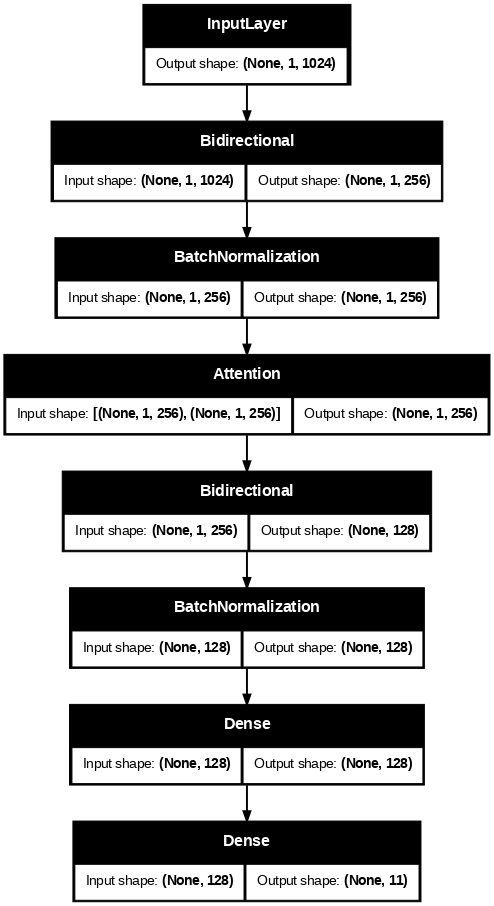

In [ ]:
plot_model(model, to_file='class1_model.png', show_shapes=True, dpi=70)

Приступим к обучению модели

In [ ]:
history = model.fit(X_train_reshaped, y_train_encoded, epochs=500, batch_size=32,
                    validation_data=(X_test_reshaped, y_test_encoded),
                    callbacks=[reduce_lr, lr_scheduler, checkpoint])


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1098 - loss: 4.9272
Epoch 1: val_accuracy improved from -inf to 0.11570, saving model to best_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.1098 - loss: 4.9274 - val_accuracy: 0.1157 - val_loss: 3.6947 - learning_rate: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 0.0001009000000000001.
Epoch 2/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1252 - loss: 4.7350
Epoch 2: val_accuracy improved from 0.11570 to 0.23140, saving model to best_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.1256 - loss: 4.7318 - val_accuracy: 0.2314 - val_loss: 3.6138 - learning_rate: 1.0090e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00020079999999999997.
Epoch 3/500
69/71 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2844 - loss: 3.7639
Epoch 3: val_accuracy improved from 0.23140 to 0.5454

Сохраним кодировщик, чтобы использовать его на backendе

In [ ]:
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

Сохраним модель в формате ONNX

In [ ]:
!pip install tf2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 50.5 MB/s eta 0:00:00


In [ ]:
model.save('class_model.keras')

loaded_model = tf.keras.models.load_model('best_model.keras')

spec = (tf.TensorSpec((None, 1, X_train_vectorized.shape[1]), tf.float32, name="input"),)
model_proto, _ = tf2onnx.convert.from_keras(loaded_model, input_signature=spec, opset=13)

with open("best_model.onnx", "wb") as f:
    f.write(model_proto.SerializeToString())

Оценим качество модели с помощью метрик

In [ ]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('best_model.keras')

y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test_encoded, y_pred_classes))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.95      0.95      0.95        21
           2       1.00      1.00      1.00         4
           3       1.00      0.91      0.95        11
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7       0.92      0.86      0.89        14
           8       1.00      1.00      1.00         2
           9       0.94      1.00      0.97        15
          10       0.88      0.88      0.88        34

    accuracy                           0.93       121
   macro avg       0.94      0.96      0.95       121
weighted avg       0.94      0.93      0.93       121



# Предсказание показателя "Классификатор 2 уровня"

In [ ]:
faq = pd.read_excel("01_База_знаний.xlsx")
faq.head()

,Тема,Вопрос из БЗ,Ответ из БЗ,Классификатор 1 уровня,Классификатор 2 уровня
0,Что нельзя публиковать на RUTUBE,Что нельзя публиковать на RUTUBE?,Чужой контент без разрешения автора или правоо...,МОДЕРАЦИЯ,Отклонение/блокировка видео
1,Почему могут отключить монетизацию на видео и ...,Почему могут отключить монетизацию из-за автор...,"Монетизация может отключиться, если на вашем к...",МОНЕТИЗАЦИЯ,Отключение/подключение монетизации
2,Почему могут отключить монетизацию на видео и ...,Почему могут отключить монетизацию из-за искус...,Монетизация на RUTUBE зависит в том числе от к...,МОНЕТИЗАЦИЯ,Отключение/подключение монетизации
3,Почему могут отключить монетизацию на видео и ...,"Для каких статусов доступна монетизация, и поч...","Монетизацию на RUTUBE можно подключить, если в...",МОНЕТИЗАЦИЯ,Отключение/подключение монетизации
4,Авторское право,Какой контент можно использовать для монетизац...,"То, что вы создали сами: видео, которое вы сня...",МОНЕТИЗАЦИЯ,Отключение/подключение монетизации


Удалим из датасета колонки, которые не используются для предсказания показателя "Классификатор 1 уровня" (колонки "Тема" и "Ответ из БЗ" не используются по той причине, что их нельзя извлечь из пользовательского соглашения, а колонки "Классификатор 1 уровня" используется для другой задачи)

In [ ]:
faq = faq.drop(['Тема', 'Ответ из БЗ', 'Классификатор 1 уровня'], axis=1)
faq.head()

,Вопрос из БЗ,Классификатор 2 уровня
0,Что нельзя публиковать на RUTUBE?,Отклонение/блокировка видео
1,Почему могут отключить монетизацию из-за автор...,Отключение/подключение монетизации
2,Почему могут отключить монетизацию из-за искус...,Отключение/подключение монетизации
3,"Для каких статусов доступна монетизация, и поч...",Отключение/подключение монетизации
4,Какой контент можно использовать для монетизац...,Отключение/подключение монетизации


Переименуем колонки более лаконично для удобства

In [ ]:
faq.rename(columns={
    'Вопрос из БЗ': 'question',
    'Классификатор 2 уровня': 'class'
}, inplace=True)

Загрузим данные о реальных кейсах и посмотрим на них

In [ ]:
data = pd.read_excel("02_Реальные_кейсы.xlsx")
data.head()

,Вопрос пользователя,Ответ сотрудника,Вопрос из БЗ,Ответ из БЗ,Классификатор 1 уровня,Классификатор 2 уровня
0,Здравствуйте! Можно уточнить причины Правилhtt...,Добрый день!\nЧто нельзя публиковать на RUTUBE...,Что нельзя публиковать на RUTUBE?,Чужой контент без разрешения автора или правоо...,МОДЕРАЦИЯ,Отклонение/блокировка видео
1,"Добрый вечер, какой топ причин блокировки виде...",Добрый вечер!\nЧто заперщено публиковать на RU...,Что нельзя публиковать на RUTUBE?,Чужой контент без разрешения автора или правоо...,МОДЕРАЦИЯ,Отклонение/блокировка видео
2,"Все пишут, что монетизация на рутубе отключает...","Добрый день! \nМонетизация может отключиться, ...",Почему могут отключить монетизацию из-за автор...,"Монетизация может отключиться, если на вашем к...",МОНЕТИЗАЦИЯ,Отключение/подключение монетизации
3,Что запрещено в монетизации и что можно выклад...,"Здравствуйте!\nМонетизация может отключиться, ...",Почему могут отключить монетизацию из-за автор...,"Монетизация может отключиться, если на вашем к...",МОНЕТИЗАЦИЯ,Отключение/подключение монетизации
4,"Чтобы не отключали монетизацию, надо, чтобы я ...","Для монетизации можно использовать то, что вы ...",Почему могут отключить монетизацию из-за автор...,"Монетизация может отключиться, если на вашем к...",МОНЕТИЗАЦИЯ,Отключение/подключение монетизации


Удалим лишние колонки так, чтобы оставшиеся соответствовали колонкам базы знаний (датасет faq)

In [ ]:
data = data.drop(['Ответ сотрудника', 'Вопрос из БЗ', 'Ответ из БЗ', 'Классификатор 1 уровня'], axis=1)
data.head()


,Вопрос пользователя,Классификатор 2 уровня
0,Здравствуйте! Можно уточнить причины Правилhtt...,Отклонение/блокировка видео
1,"Добрый вечер, какой топ причин блокировки виде...",Отклонение/блокировка видео
2,"Все пишут, что монетизация на рутубе отключает...",Отключение/подключение монетизации
3,Что запрещено в монетизации и что можно выклад...,Отключение/подключение монетизации
4,"Чтобы не отключали монетизацию, надо, чтобы я ...",Отключение/подключение монетизации


Переименуем колонки аналогичным образом

In [ ]:
data.rename(columns={
    'Вопрос пользователя': 'question',
    'Классификатор 2 уровня': 'class'
}, inplace=True)

В ячейках датасета со значением "Приложение" содержится деффект, уберем его

In [ ]:
faq['class'] = faq['class'].replace('Приложение\xa0', 'Приложение')
data['class'] = data['class'].replace('Приложение\xa0', 'Приложение')

Объединим датасеты, чтобы посмотреть на полный набор имеющихся данных

In [ ]:
df = pd.concat([faq, data], ignore_index=True)
df

,question,class
0,Что нельзя публиковать на RUTUBE?,Отклонение/блокировка видео
1,Почему могут отключить монетизацию из-за автор...,Отключение/подключение монетизации
2,Почему могут отключить монетизацию из-за искус...,Отключение/подключение монетизации
3,"Для каких статусов доступна монетизация, и поч...",Отключение/подключение монетизации
4,Какой контент можно использовать для монетизац...,Отключение/подключение монетизации
...,...,...
1122,Добрый день! Как добавить таймкоды в видео?,Загрузка видео
1123,Как добавить временные интервалы,Загрузка видео
1124,В каком формате добавляются таймкоды?,Загрузка видео
1125,Как мне правильно указать тайм-код?,Загрузка видео


In [ ]:
#информация о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  1127 non-null   object
 1   class     1127 non-null   object
dtypes: object(2)
memory usage: 17.7+ KB


In [ ]:
# количество классов в датасете с базой знаний
len(faq['class'].unique())

39

In [ ]:
# количество классов в датасете с реальными кейсами
len(data['class'].unique())

39

Как видим, классов одинаковое количество, но нужно убедиться, что они одинаковые

In [ ]:
faq['class'].unique().sort() == data['class'].unique().sort()

True

Действительно, это так

In [ ]:
df['class'].unique()

array(['Отклонение/блокировка видео',
       'Отключение/подключение монетизации', 'Нарушение авторских прав',
       'Персонализация', 'Приложение', 'Отсутствует',
       'Регистрация/Авторизация', 'Удаление аккаунта', 'Студия RUTUBE',
       'Навигация', 'Монетизация', 'Загрузка видео', 'Трансляция',
       'Аналитика', 'Управление трансляцией', 'Комментарии',
       'Воспроизведение видео', 'Продвижение канала',
       'Система рекомендаций', 'Персонализация 0', 'История поиска',
       'Плеер', 'Недоступность видео', 'ТВ-эфиры', 'Управление плеером',
       'Просмотр трансляции', 'Встраивание видео',
       'Смена категории/возрастные ограничения', 'Верификация',
       'Статистика по монетизации', 'Подключение/отключение рекламы',
       'Долгая модерация', 'Блокировка канала',
       'Подключение/отключение донатов', 'Чат/Комментарии',
       'Платный контент', 'Запрещенный контент',
       'Перенос видео с Youtube', 'Текстовый поиск'], dtype=object)

Посмотрим на распределение данных по классам

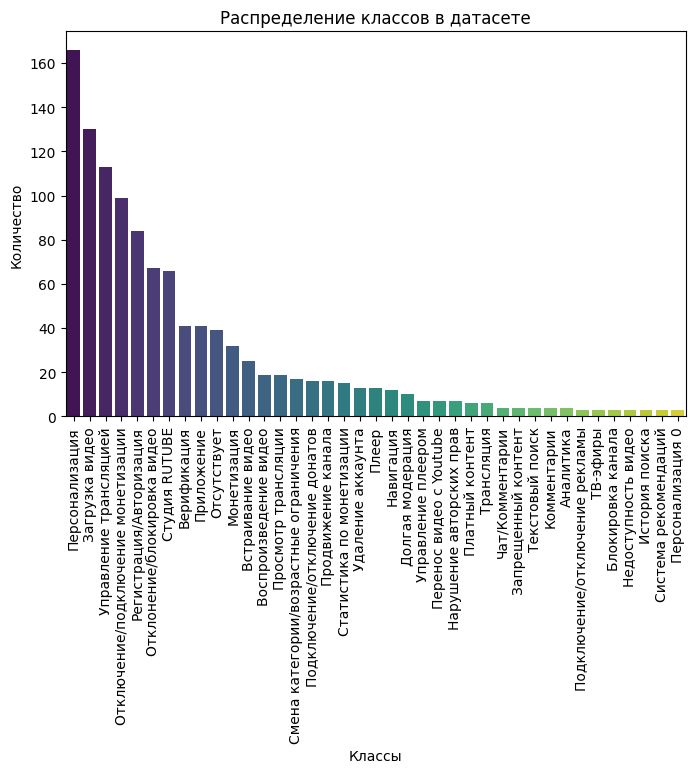

In [ ]:
# Получаем количество экземпляров каждого класса
class_counts = df['class'].value_counts()

# Создаем фигуру с заданными размерами
plt.figure(figsize=(8, 5))

# Создаем столбчатую диаграмму с использованием библиотеки seaborn
# x - метки классов, y - соответствующее количество классов
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

plt.xlabel('Классы')
plt.ylabel('Количество')
plt.title('Распределение классов в датасете')

plt.xticks(rotation=90)

plt.show()

В данных наблюдается сильный дисбаланс классов, чтобы решить эту проблему, был сгенерирован датасет, в котором к базе знаний вручную были добавлены синтетические данные путем перефразирования уже имеющихся вопросов, классы которых имеются в малом наличии в датасете

In [98]:
synth_data_cls2 = pd.read_csv('synth_data_cls2.csv')

In [99]:
synth_data_cls2

,Unnamed: 0,question,class
0,0,Что нельзя публиковать на RUTUBE?,Отклонение/блокировка видео
1,1,Почему могут отключить монетизацию из-за автор...,Отключение/подключение монетизации
2,2,Почему могут отключить монетизацию из-за искус...,Отключение/подключение монетизации
3,3,"Для каких статусов доступна монетизация, и поч...",Отключение/подключение монетизации
4,4,Какой контент можно использовать для монетизац...,Отключение/подключение монетизации
...,...,...,...
1470,1470,"Почему видео, загруженное несколько дней назад...",Долгая модерация
1471,1471,"Какие факторы могли повлиять на то, что видео,...",Долгая модерация
1472,1472,"Почему видео, которое было загружено два месяц...",Долгая модерация
1473,1473,"Почему видео, которое было загружено неделю на...",Долгая модерация


Объединяем синтетические данные, данные базы знаний и данные реальных кейсов, чтобы посмотреть, как изменилось распределение данных

In [102]:
df = pd.concat([synth_data_cls2, data], ignore_index=True)

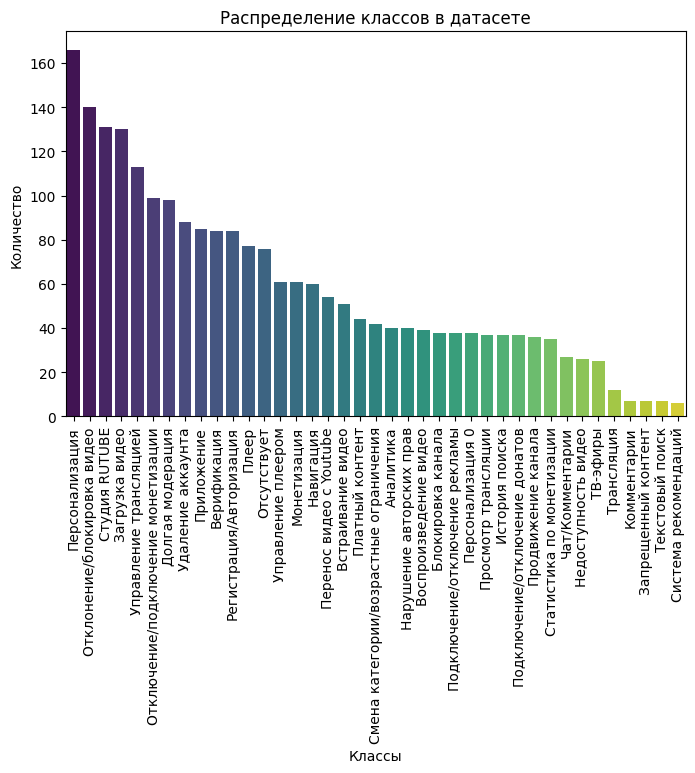

In [103]:
class_counts = df['class'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

plt.xlabel('Классы')
plt.ylabel('Количество')
plt.title('Распределение классов в датасете')

plt.xticks(rotation=90)

plt.show()

Как видим, дизбаланс стал не таким резким, но еще больше синтетических данных не было добавлено, чтобы не пострадало качество модели

Далее поделим данные на тестовую и тренировочную выборки, при этом на обучение идут синтетические данные, данные базы знаний и часть данных реальных кейсов, а на тест идут только данные из реальных кейсов

In [106]:
# Загружаем токенизатор и модель из предобученной модели
tokenizer = AutoTokenizer.from_pretrained("deepvk/User-bge-m3")
model = AutoModel.from_pretrained("deepvk/User-bge-m3")

# Подготовка обучающих и тестовых данных
# Преобразуем каждый элемент в X_train в строку, если это str, int или float, иначе используем пустую строку
X_train = [str(q) if isinstance(q, (str, int, float)) else "" for q in X_train]
# Аналогично преобразуем каждый элемент в X_test
X_test = [str(q) if isinstance(q, (str, int, float)) else "" for q in X_test]
# Извлекаем вопросы из тестовых данных в виде списка
X_test = test_data['question'].tolist()
# Извлекаем соответствующие классы для тестовых данных
y_test = test_data['class']

# Кодируем метки для обучающего и тестового наборов
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Обучаем и трансформируем метки для обучения
y_test_encoded = label_encoder.transform(y_test)        # Трансформируем тестовые метки

# Функция для векторизации текстов с использованием модели
def vectorize_texts(texts, batch_size=32):
    vectors = []  # Список для хранения векторных представлений
    # Обрабатываем тексты партиями
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]  # Получаем партию текстов
        # Проверяем, что все элементы в партии являются строками
        if not all(isinstance(text, str) for text in batch):
            raise ValueError("Все элементы в партии должны быть строками.")
        # Токенизируем партию и подготавливаем входные данные для модели
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        # Отключаем вычисление градиентов для повышения эффективности
        with torch.no_grad():
            outputs = model(**inputs)  # Прямой проход через модель
        # Вычисляем среднее значение последнего скрытого состояния для векторного представления
        vectors.append(outputs.last_hidden_state.mean(dim=1).numpy())
    return np.vstack(vectors)  # Объединяем все векторы в один массив

# Векторизуем обучающие и тестовые данные
X_train_vectorized = vectorize_texts(X_train)
X_test_vectorized = vectorize_texts(X_test)

# Изменяем форму векторизованных данных, добавляя дополнительное измерение (для совместимости с некоторыми моделями)
X_train_reshaped = X_train_vectorized.reshape(X_train_vectorized.shape[0], 1, X_train_vectorized.shape[1])
X_test_reshaped = X_test_vectorized.reshape(X_test_vectorized.shape[0], 1, X_test_vectorized.shape[1])

# Настройка ранней остановки для предотвращения переобучения
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
# Настройка уменьшения скорости обучения при плато
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)


In [ ]:
# Функция для вычисления циклической скорости обучения
def cyclical_learning_rate(epoch, lr, min_lr=1e-6, max_lr=1e-3, step_size=10):
    # Определяем текущий цикл на основе эпохи и шага
    cycle = math.floor(1 + epoch / (2 * step_size))
    # Вычисляем позицию в цикле
    x = abs(epoch / step_size - 2 * cycle + 1)
    # Вычисляем новую скорость обучения на основе минимальной и максимальной скорости
    new_lr = min_lr + (max_lr - min_lr) * max(0, (1 - x))
    return new_lr

# Создаем планировщик скорости обучения, используя функцию циклической скорости обучения
lr_scheduler = LearningRateScheduler(lambda epoch, lr: cyclical_learning_rate(epoch, lr), verbose=1)

# Определяем входной слой с формой обучающих данных
input_layer = Input(shape=(1, X_train_vectorized.shape[1]))

# Добавляем двунаправленный слой LSTM с 128 юнитами и возвращаем последовательности
lstm_out = Bidirectional(LSTM(128, return_sequences=True))(input_layer)

# Применяем механизм внимания к выходу LSTM
attention_out = Attention()([lstm_out, lstm_out])

# Добавляем еще один двунаправленный слой LSTM с 64 юнитами
lstm_out2 = Bidirectional(LSTM(64))(attention_out)

# Добавляем плотный слой с 128 юнитами и активацией ReLU, включая L2 регуляризацию
dense_out = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(lstm_out2)

# Определяем выходной слой с активацией softmax для многоклассовой классификации
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(dense_out)

# Создаем модель, указывая входные и выходные слои
model = Model(inputs=input_layer, outputs=output_layer)

In [112]:
# Создаем объект для сохранения лучшей модели на основе валидационной точности
checkpoint = ModelCheckpoint(
    'best_model.keras',       # Имя файла, в который будет сохранена модель
    monitor='val_accuracy',   # Метрика для отслеживания (валидационная точность)
    save_best_only=True,      # Сохранять только лучшую модель
    mode='max',               # Режим, указывающий, что мы хотим максимизировать точность
    verbose=1                 # Уровень вывода информации о процессе сохранения модели
)

# Компилируем модель с заданной функцией потерь, оптимизатором и метриками
model.compile(
    loss='sparse_categorical_crossentropy',  # Функция потерь для многоклассовой классификации
    optimizer='adam',                        # Оптимизатор Adam
    metrics=['accuracy']                     # Метрики, которые будут отслеживаться во время обучения
)

In [114]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1, 1024)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 1, 256)         │      1,180,672 │ input_layer_2[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 1, 256)         │          1,024 │ bidirectional_4[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 1, 256)         │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_2 (Attention)   │ (None, 1, 256)         │              0 │ dropout_6[0][0],       │
│                           │                        │                │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 128)            │        164,352 │ attention_2[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 128)            │            512 │ bidirectional_5[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 128)            │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         16,512 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 39)             │          5,031 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,368,103 (5.22 MB)

 Trainable params: 1,367,335 (5.22 MB)

 Non-trainable params: 768 (3.00 KB)

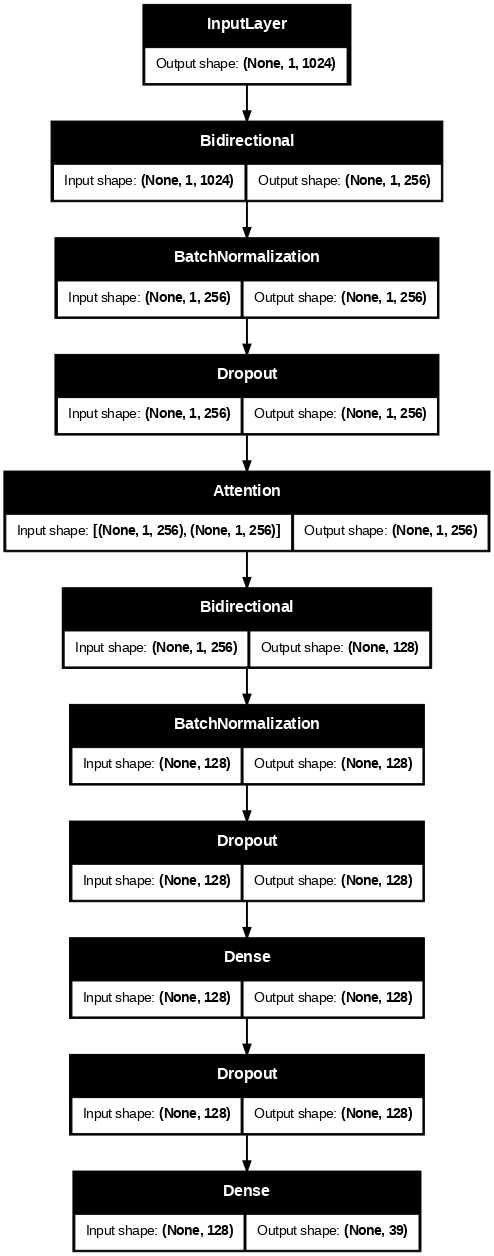

In [110]:
plot_model(model, to_file='class2_model.png', show_shapes=True, dpi=70)

Приступим к обучению модели

In [ ]:
# Обучаем модель с обучающими данными, валидационными данными и заданными обратными вызовами
history = model.fit(X_train_reshaped, y_train_encoded, epochs=300, batch_size=32,
                    validation_data=(X_test_reshaped, y_test_encoded),
                    callbacks=[reduce_lr, lr_scheduler, checkpoint])

# Находим лучшую валидационную точность и соответствующую эпоху
best_accuracy = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_accuracy) + 1

# Печатаем лучшую точность и эпоху, на которой она была достигнута
print(f'Лучшее значение accuracy: {best_accuracy:.4f} на эпохе: {best_epoch}')


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0136 - loss: 4.9361
Epoch 1: val_accuracy improved from -inf to 0.00826, saving model to best_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.0137 - loss: 4.9360 - val_accuracy: 0.0083 - val_loss: 4.9312 - learning_rate: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 0.0001009000000000001.
Epoch 2/300
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0966 - loss: 4.8499
Epoch 2: val_accuracy improved from 0.00826 to 0.20661, saving model to best_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0979 - loss: 4.8458 - val_accuracy: 0.2066 - val_loss: 4.4610 - learning_rate: 1.0090e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00020079999999999997.
Epoch 3/300
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3046 - loss: 4.1068
Epoch 3: val_accuracy improved from 0.20661 to 0.58678, saving model to best_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - ac

Сохраним кодировщик, чтобы использовать его на backendе

In [ ]:
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

Сохраним модель в формате ONNX

In [ ]:
model.save('best_model.keras')

loaded_model = tf.keras.models.load_model('best_model.keras')

spec = (tf.TensorSpec((None, 1, X_train_vectorized.shape[1]), tf.float32, name="input"),)
model_proto, _ = tf2onnx.convert.from_keras(loaded_model, input_signature=spec, opset=13)

with open("best_model.onnx", "wb") as f:
    f.write(model_proto.SerializeToString())

Оценим качество модели с помощью метрик

In [ ]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('best_model.keras')

y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test_encoded, y_pred_classes))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         2
           4       1.00      0.67      0.80         3
           5       0.50      1.00      0.67         1
           6       0.88      1.00      0.93        14
          10       1.00      0.50      0.67         4
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          14       0.78      1.00      0.88         7
          15       0.83      0.91      0.87        11
          16       0.60      0.75      0.67         4
          17       1.00      1.00      1.00         1
          18       0.88      0.83      0.86        18
          20       1.00      1.00      1.00         1
          21       0.50      1.00      0.67         1
          22       0.67      1.00      0.8